<a href="https://colab.research.google.com/github/JesseKanter/qura_isduplicate/blob/master/qura_isduplicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
colab_mode = True
download_rawData = True
setup = True

ROOT_DIR = '/content/'
WEIGHTS_FILENAME = 'qura_LSTM.h5'
WEIGHTS_FILE = os.path.join(ROOT_DIR, WEIGHTS_FILENAME)

In [0]:
from google.colab import files

In [0]:
if colab_mode and download_rawData:
  files.upload()

Saving kaggle.json to kaggle.json


In [0]:
if colab_mode and download_rawData:
  ! mkdir /root/.kaggle/
  ! mv /content/kaggle.json /root/.kaggle/

In [0]:
if setup:
  ! pip install kaggle

## Download the Quora Question Pairs dataset

In [0]:
! kaggle competitions download -c quora-question-pairs

100% 4.95M/4.95M [00:00<00:00, 43.7MB/s]

 80% 17.0M/21.2M [00:00<00:00, 20.5MB/s]
100% 21.2M/21.2M [00:00<00:00, 23.0MB/s]
 93% 105M/112M [00:02<00:00, 56.2MB/s] 
100% 112M/112M [00:02<00:00, 55.6MB/s]


In [0]:
#! kaggle datasets download -d terenceliu4444/glove6b100dtxt

In [0]:
! rm /root/.kaggle/kaggle.json

In [0]:
if setup:
  ! unzip -q /content/train.csv.zip
  ! unzip -q /content/test.csv.zip
  ! unzip -q /content/sample_submission.csv.zip

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict

In [0]:
train_orig =  pd.read_csv('train.csv', header=0)
test_orig =  pd.read_csv('test.csv', header=0)

train_orig['question1'].fillna('', inplace=True)
train_orig['question2'].fillna('', inplace=True)

test_orig['question1'].fillna('', inplace=True)
test_orig['question2'].fillna('', inplace=True)


In [0]:
import string
from nltk.corpus import stopwords

In [0]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
common_words=stopwords.words('english') #['what', 'why', 'is', 'the', 'a', 'i', 'how', 'by', 'to', 'in']

In [0]:
def clean_questions(row):
  new_row=row.copy()
  #make  questions lower case
  new_row[0]=new_row[0].lower()
  new_row[1]=new_row[1].lower()
  
  #remove punctuation
  new_row[0] = [char for char in new_row[0] if char not in string.punctuation]
  new_row[0] = ''.join(new_row[0])
  new_row[1] = [char for char in new_row[1] if char not in string.punctuation]
  new_row[1] = ''.join(new_row[1])
  
  #remove stop words
  new_row[0] = [word for word in new_row[0].split() if word not in common_words]
  new_row[0] = ' '.join(new_row[0])
  new_row[1] = [word for word in new_row[1].split() if word not in common_words]
  new_row[1] = ' '.join(new_row[1])
  
  return new_row
  
  


In [0]:
train_orig[['clean_question1','clean_question2']] = train_orig[['question1','question2']].apply(clean_questions, axis=1, raw=True)


In [0]:
test_orig[['clean_question1','clean_question2']] = test_orig[['question1','question2']].apply(clean_questions, axis=1, raw=True)

In [0]:
def sim_words_ratio(row):
  s1=row[0].lower()
  s2=row[1].lower()
  set1=set(s1.split())
  set2=set(s2.split())
  norm_fac=1
  if 0 not in [len(set1),len(set2)]:
    norm_fac=max([len(set1),len(set2)])   
  return len(set1.intersection(set2))/norm_fac
  

In [0]:
train_orig['q1_q2_same_word_ratio'] = train_orig[['clean_question1','clean_question2']].apply(sim_words_ratio, axis=1, raw=True)
test_orig['q1_q2_same_word_ratio'] = test_orig[['clean_question1','clean_question2']].apply(sim_words_ratio, axis=1, raw=True)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
train_orig.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,clean_question1,clean_question2,q1_q2_same_word_ratio,uwords_question1,uwords_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market,0.833333,india,


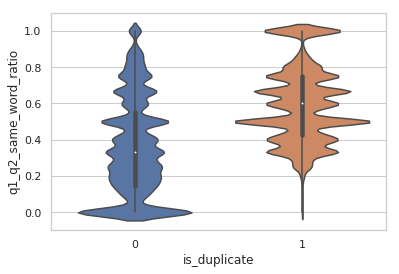

In [0]:
sns.set(style="whitegrid")
sns.violinplot(x='is_duplicate',y='q1_q2_same_word_ratio',data=train_orig)

In [0]:
def diff_words(row):
  new_row=row.copy()

  
  new_row[0]=new_row[0].lower()
  new_row[1]=new_row[1].lower()
 
  s1_new=[word for word in new_row[0].split() if word not in new_row[1].split()]
  new_row[1]=[word for word in new_row[1].split() if word not in new_row[0].split()]
  
  
  new_row[0]=s1_new
  
  new_row[0] = ' '.join(new_row[0])
  new_row[1] = ' '.join(new_row[1])
  
  return new_row
  

In [0]:
train_orig[['uwords_question1','uwords_question2']] = train_orig[['clean_question1','clean_question2']].apply(diff_words, axis=1, raw=True)


In [0]:
test_orig[['uwords_question1','uwords_question2']] = test_orig[['clean_question1','clean_question2']].apply(diff_words, axis=1, raw=True)


In [0]:
df_all = pd.concat((train_orig, test_orig))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
df_all.tail(2)

,clean_question1,clean_question2,id,is_duplicate,q1_q2_same_word_ratio,qid1,qid2,question1,question2,test_id,uwords_question1,uwords_question2
2345794,best worst things public transit proddatur and...,best worst things examination public transit v...,NaN,NaN,0.833333,NaN,NaN,What were the best and worst things about publ...,What are the best and worst things examination...,2345794.0,proddatur,examination visakhapatnam
2345795,best medication equation erectile dysfunction,get rid erectile dysfunction,NaN,NaN,0.400000,NaN,NaN,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?,2345795.0,best medication equation,get rid


#Create Vocab

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [0]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(itertools.chain(df_all['clean_question1'], df_all['clean_question2']))
other_index = len(counts_vectorizer.vocabulary_)

In [0]:
other_index

9999

# Prep Data


In [0]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

In [0]:
def find_max_words(X):
  #r_len=[]
  max=1
  for text in X:
      word=word_tokenize(text)
      le=len(word)
      #r_len.append(l)
      if le>max:
        max=le
    
  #MAX_REVIEW_LEN=np.max(r_len)
  return max #MAX_REVIEW_LEN

In [0]:
#find_max_words(df_all.uwords_question1.values)

In [0]:
def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)



I think the point of create_padded_seqs, is to take an input text and only keep the words that we put in vocab, and give a padding if not

In [0]:
Xr_train, Xr_val, X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(df_all[df_all['id'].notnull()]['q1_q2_same_word_ratio'], create_padded_seqs(df_all[df_all['id'].notnull()]['clean_question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['clean_question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.3, random_state=1989)

In [0]:
X2_train.max()

9999

In [0]:
import keras.layers as lyr
from keras.models import Model

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
inputr_tensor = lyr.Input((1,))
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])


#seq_embedding_layer_r = lyr.LSTM(256, activation='tanh')


words_embedding_layer_1 = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer_1 = lyr.LSTM(256, activation='tanh')

words_embedding_layer_2 = lyr.Embedding(X2_train.max() + 1, 100)
seq_embedding_layer_2 = lyr.LSTM(256, activation='tanh')

#seq_r = lyr.LSTM(256, activation='tanh')(inputr_tensor)
seq_embedding_1 = lambda tensor: seq_embedding_layer_1(words_embedding_layer_1(tensor))
seq_embedding_2 = lambda tensor: seq_embedding_layer_2(words_embedding_layer_2(tensor))

merge_layer_1 = lyr.multiply([seq_embedding_1(input1_tensor), seq_embedding_1(input2_tensor),inputr_tensor])
merge_layer_2 = lyr.multiply([seq_embedding_2(input1_tensor), seq_embedding_2(input2_tensor),inputr_tensor])

# word_lyr_1=seq_embedding_1(input1_tensor)
# word_lyr_2=seq_embedding_2(input2_tensor)


#dense_layer_r = lyr.Dense(128, activation='sigmoid')(seq_embedding_layer_r)
dense_layer_1 = lyr.Dense(128, activation='sigmoid')(merge_layer_1)
dense_layer_2 = lyr.Dense(128, activation='sigmoid')(merge_layer_2)

concat_layer = lyr.concatenate([dense_layer_1, dense_layer_2])

dropout_layer_first=lyr.Dropout(.5)(concat_layer)

fc_dense = lyr.Dense(128, activation='sigmoid')(dropout_layer_first)

dropout_layer_second=lyr.Dropout(.5)(fc_dense)

ouput_layer = lyr.Dense(1, activation='sigmoid')(dropout_layer_second)

model = Model([inputr_tensor, input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 10, 100)      1000000     input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 10, 100)      1000000     input_14[0][0]                   
          

In [0]:
model.fit([Xr_train, X1_train, X2_train], y_train, 
          validation_data=([Xr_val, X1_val, X2_val], y_val), 
          batch_size=128, epochs=6, verbose=2, callbacks=[checkpointer])

Train on 283003 samples, validate on 121287 samples
Epoch 1/6
 - 242s - loss: 0.3401 - val_loss: 0.3945

Epoch 00001: val_loss did not improve from 0.39201
Epoch 2/6
 - 243s - loss: 0.3209 - val_loss: 0.4006

Epoch 00002: val_loss did not improve from 0.39201
Epoch 3/6


In [0]:

Xr_test = df_all[df_all['test_id'].notnull()]['q1_q2_same_word_ratio']
X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['clean_question1'])
X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['clean_question2'])


In [0]:
model.load_weights('weights.hdf5')
F_test = model.predict([Xr_test, X1_test, X2_test], batch_size=128, verbose=1)


2345796/2345796 [==============================] - 591s 252us/step


In [0]:
df_sub = pd.DataFrame({
        'test_id': df_all[df_all['test_id'].notnull()]['test_id'].apply(int).values,
        'is_duplicate': list(F_test[:, 0])
    }).set_index('test_id')


In [0]:
df_sub.to_csv('Kanter_submission_0709_5.csv')


In [0]:
!kaggle competitions submit -c quora-question-pairs -f Kanter_submission_0709_5.csv -m "Message"


100% 62.2M/62.2M [00:05<00:00, 11.6MB/s]
Successfully submitted to Quora Question Pairs

In [0]:
# inputr_tensor = lyr.Input(Xr_train.shape[1:])
# input1_tensor = lyr.Input(X1_train.shape[1:])
# input2_tensor = lyr.Input(X2_train.shape[1:])

# words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
# seq_embedding_layer = lyr.LSTM(256, activation='tanh')

# seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

# merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])
# merge_layer_all = lyr.multiply([merge_layer,inputr_tensor ])

# dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer_all)
# ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

# model = Model([input1_tensor, input2_tensor], ouput_layer)

# model.compile(loss='binary_crossentropy', optimizer='adam')
# model.summary()